In [63]:
import pandas as pd
import re
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from tqdm import tqdm_notebook
import pickle
import datetime
import collections

In [3]:
df_post = pd.read_csv('../out/car/df_post.csv',parse_dates=['post_date'])

In [4]:
with open('../out/car/tokens_post.txt', 'rb') as fp:   #Pickling
    tokens_post = pickle.load(fp)

In [21]:
len(tokens_post), len(df_post)

(417101, 417101)

## sentiment query with kws radius

In [5]:
# pos_txt = list(pd.read_csv('../src/positive-sentiment-words.txt',header=None)[0].values)
# neg_txt = list(pd.read_csv('../src/negative-sentiment-words.txt', header=None)[0].values)
# pos_df = pd.DataFrame({'word':pos_txt, 'score':1})
# neg_df = pd.DataFrame({'word':neg_txt, 'score':1})
# pos_df.to_excel('../src/positive_word_score.xlsx', index=False)
# neg_df.to_excel('../src/negative_word_score.xlsx', index=False)

In [6]:
pos_df = pd.read_excel('../src/positive_word_score.xlsx')
neg_df = pd.read_excel('../src/negative_word_score.xlsx')

In [7]:
# convert dataframe to default dict
pos_dict = collections.defaultdict(lambda:0 ,{word:score for word,score in zip(pos_df.word.values,pos_df.score.values)})
neg_dict = collections.defaultdict(lambda:0 ,{word:score for word,score in zip(neg_df.word.values,neg_df.score.values)})

In [32]:
def count_score(tokens_post, kws, kws_radius):
    
    idxs=[]
    scores=[]
    for i,tokens in enumerate(tokens_post):
        pos,neg = 0, 0
        lhs_idx, rhs_idx = -np.inf, -np.inf
        for j,word in enumerate(tokens):
            if word in kws:
                # append the index only one time
                if lhs_idx == -np.inf:
                    idxs.append(i)
                # update the range of search index
                if min(0,j-kws_radius) < rhs_idx:
                    lhs_idx = rhs_idx
                else:
                    lhs_idx = max(0,j-kws_radius)

                rhs_idx = min(len(tokens)-1,j+kws_radius)

                # count the score
                for k in range(lhs_idx,rhs_idx):
                    pos+=pos_dict[tokens[k]]
                    neg+=neg_dict[tokens[k]]
                
        score = pos-neg
        if lhs_idx != -np.inf:
            scores.append(score)
    
    return idxs, scores

In [95]:
def get_sentiment(df):
    df_temp = df.copy()
    df_temp = df_temp.iloc[idxs]
    df_temp['sent_score'] = scores
    df_temp['sentiment'] = df_temp.sent_score.apply(lambda x:'positive' if x>0 else 'negative' if x<0 else 'neutral')
    return df_temp

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.


Total mentions: 862 

Total mentions: 440 

Total mentions: 97 




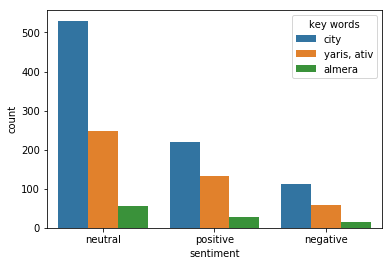

In [93]:
kws_list = [['city'],['yaris','ativ'],['almera']]
dt = datetime.date(2018,11,1)
win_len = 365
kws_radius = 10
sent_sum_list = []

for kws in tqdm_notebook(kws_list):
    idxs, scores = count_score(tokens_post, kws, kws_radius)
    df_temp = get_sentiment(df_post)
    
    # filter by datetime
    df_temp = df_temp.loc[(df_temp.post_date < dt)&\
                          (dt - df_temp.post_date.dt.date < datetime.timedelta(days=win_len))]
    
    sent_sum_df = pd.DataFrame(df_temp.sentiment.value_counts()).reset_index().rename({'sentiment':'count','index':'sentiment'},axis=1)
    sent_sum_df['key words'] = ', '.join(kws)
    sent_sum_list.append(sent_sum_df)
    
all_brand_df = pd.concat(sent_sum_list)
_ = sns.barplot(x='sentiment',y='count',hue='key words',data=all_brand_df)

In [94]:
# extract month-year and year from date time
df_post['month-year'] = df_post.post_date.progress_apply(lambda x:datetime.date(x.year,x.month,1))
df_post['year'] = df_post.post_date.dt.year

100%|██████████| 417101/417101 [00:02<00:00, 148185.50it/s]


In [97]:
df_temp_mo

,month-year,sentiment,sent_score
0,2012-12-01,negative,3
1,2012-12-01,neutral,12
2,2012-12-01,positive,5
3,2013-01-01,negative,5
4,2013-01-01,neutral,16
5,2013-01-01,positive,4
6,2013-02-01,negative,1
7,2013-02-01,neutral,13
8,2013-02-01,positive,5
9,2013-03-01,negative,4


In [98]:
kws_list = [['city'],['yaris','ativ'],['almera']]
kws_radius = 10
agg_month_list = []
agg_year_list = []

for kws in tqdm_notebook(kws_list):
    idxs, scores = count_score(tokens_post, kws, kws_radius)
    df_temp = get_sentiment(df_post)
    
    # aggregate
    df_temp_mo = df_temp.groupby(['month-year','sentiment'])['sent_score'].count().reset_index()
    df_temp_mo['key words'] = ', '.join(kws)
    agg_month_list.append(df_temp_mo)
    df_temp_y = df_temp.groupby(['year','sentiment'])['sent_score'].count().reset_index()
    df_temp_y['key words'] = ', '.join(kws)
    agg_year_list.append(df_temp_y)

mo_all_df = pd.concat(agg_month_list)
mo_all_df['kws-sent'] = mo_all_df['key words'] + mo_all_df['sentiment']
_ = sns.lineplot(x='month-year', y='sent_score', hue='sentiment',data=mo_all_df)
plt.show()
# _ = sns.lineplot(x='year', y='sent_score', hue='sentiment',data=df_temp_y)
# plt.show()

In [101]:
pd.concat(agg_month_list)

,month-year,sentiment,sent_score,key words
0,2012-12-01,negative,17,city
1,2012-12-01,neutral,69,city
2,2012-12-01,positive,31,city
3,2013-01-01,negative,12,city
4,2013-01-01,neutral,70,city
5,2013-01-01,positive,15,city
6,2013-02-01,negative,9,city
7,2013-02-01,neutral,70,city
8,2013-02-01,positive,24,city
9,2013-03-01,negative,19,city


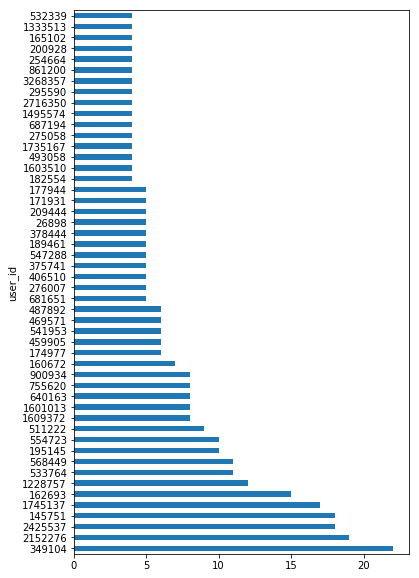

In [26]:
df_temp['user_id'] = df_temp['user_id'].astype(int)

# visualize engagement by top user
df_temp_user = df_temp.groupby('user_id')['sentiment'].count().reset_index().sort_values('sentiment',ascending=False)

df_temp_user.rename({'sentiment':'total_post'},axis=1,inplace=True)

_ = df_temp_user.head(50).plot(x='user_id',y='total_post',kind='barh',legend=False,figsize=(6,10))

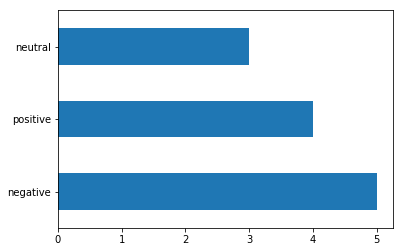

In [27]:
# single user view
user_id = 1228757
df_temp_1u = df_temp.loc[df_temp.user_id == user_id]

_ = df_temp_1u.sentiment.value_counts().plot('barh')